Part 4 contains the following
1. Feature importance
2. Explainability with Shap values

In [22]:
import pandas as pd
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.metrics import confusion_matrix
import seaborn as sns 
import matplotlib.pyplot as plt
import pickle

In [7]:
# load the train - test set data
X_train = pd.read_csv("../Datasets/X_train.csv", index_col="Unnamed: 0")
X_test = pd.read_csv("../Datasets/X_test.csv", index_col="Unnamed: 0")

y_train = pd.read_csv("../Datasets/y_train.csv", index_col="Unnamed: 0")
y_test = pd.read_csv("../Datasets/y_test.csv", index_col="Unnamed: 0")

In [12]:
# load the model
clf = pickle.load(open("../Models/XGB.pkl", "rb"))

In [13]:
# tree based models are a good candidate for machine learning explainability
importance_dict = {
    "feature_name": X_train.columns,
    "feature_importance": clf.feature_importances_
}

importance_df = pd.DataFrame(importance_dict)
importance_df.sort_values("feature_importance", ascending=False)

,feature_name,feature_importance
12,capital_evaluation,0.342393
11,capital_estimate,0.188254
16,marital_status_Married-civ-spouse,0.085616
23,workclass_Local-gov,0.072388
1,occupation_level,0.056454
2,education_num,0.045427
7,hours_per_week,0.035790
26,workclass_Self-emp-not-inc,0.022066
10,yearly_salary_estimate,0.021086
0,age,0.020573


In [14]:
# from a first view it appeas that marital status features are not important at all except from people married with civilian spouse
# instread of using all the information the feature can be reduced to a binary format -- married-civ-spouse or not
# this is also to avoid adding extra features that only contribute as noise

retain_columns = [col for col in X_train.columns if not col.startswith("marital_status")] + ["marital_status_Married-civ-spouse"]
X_train_red = X_train[retain_columns]
X_train_red = X_train_red.rename(columns={"marital_status_Married-civ-spouse": "married_civ"})

X_test_red = X_test[retain_columns]
X_test_red = X_test_red.rename(columns={"marital_status_Married-civ-spouse": "married_civ"})

# From workclass only values local-gov, self-empl-inc and self-emp-not-inc are important to the model
# both self employed values can be grouped into one
retain_columns = [col for col in X_test_red.columns if not col.startswith("workclass")]\
    + ["workclass_Local-gov", "workclass_Self-emp-inc", "workclass_Self-emp-not-inc"]
X_train_red = X_train_red[retain_columns]
X_train_red["workclass_self_emp"] = X_train_red["workclass_Self-emp-inc"] + X_train_red["workclass_Self-emp-not-inc"]
X_train_red = X_train_red.drop(columns = ["workclass_Self-emp-inc", "workclass_Self-emp-not-inc"])

X_test_red = X_test_red[retain_columns]
X_test_red["workclass_self_emp"] = X_test_red["workclass_Self-emp-inc"] + X_test_red["workclass_Self-emp-not-inc"]
X_test_red = X_test_red.drop(columns = ["workclass_Self-emp-inc", "workclass_Self-emp-not-inc"])

# sex and hours_band are also non important
X_train_red = X_train_red.drop(columns=["sex", "hours_band"])
X_test_red = X_test_red.drop(columns=["sex", "hours_band"])

In [18]:
clf = XGBClassifier(use_label_encoder=False, njobs=-1)
clf.fit(X_train_red, y_train)
y_pred = clf.predict(X_test_red)

confusion_matrix(y_test, y_pred)

[23:29:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "njobs" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[23:29:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\Users\Anastasia\Desktop\campainsenv\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


array([[618,   4],
       [  5,  50]], dtype=int64)

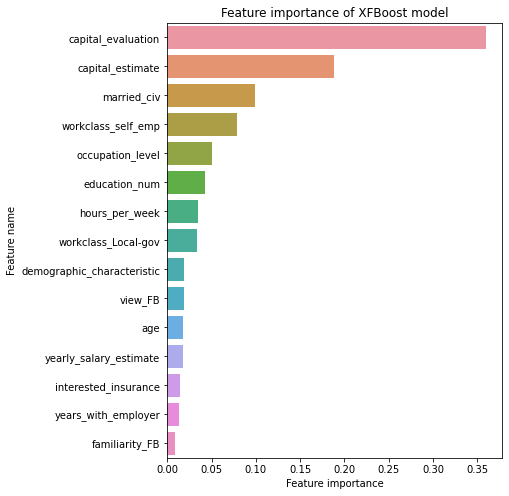

In [21]:
importance_dict = {
    "feature_name": X_train_red.columns,
    "feature_importance": clf.feature_importances_
}

importance_df = pd.DataFrame(importance_dict)
importance_df = importance_df.sort_values("feature_importance", ascending=False)

plt.figure(figsize=(6, 8))

splot = sns.barplot(data=importance_df, x="feature_importance", y="feature_name")
splot.set(xlabel="Feature importance",
          ylabel="Feature name",
          title="Feature importance of XFBoost model")

plt.show()

C:\Users\Anastasia\AppData\Local\Temp\ipykernel_68472\716827973.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


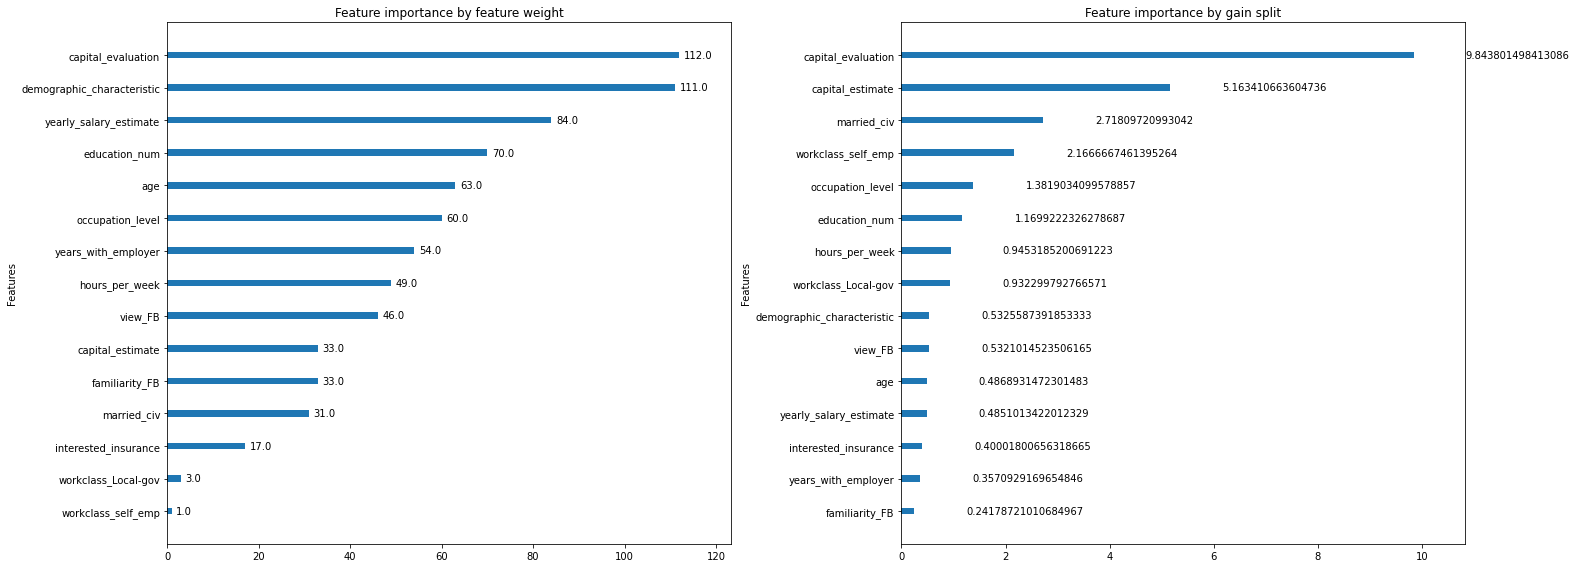

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(22, 8))

# weight -- number of times a feature appears in a tree
xgb.plot_importance(booster=clf, xlabel=None, grid=False, importance_type="weight",
                    ax=axes[0], title="Feature importance by feature weight")

# gain -- average gain of splits which use the feature
xgb.plot_importance(booster=clf, xlabel=None, grid=False, importance_type="gain",
                    ax=axes[1], title="Feature importance by gain split")

plt.tight_layout()
fig.show()